In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import transforms as T
from torch.utils.data import SubsetRandomSampler as SRS 
from torch.utils.data import DataLoader
from data.Dataset import Proteins
from models import resnet101
from sklearn.model_selection import train_test_split
from config import DefaultConfig
import time
import os

In [2]:
opt = DefaultConfig()

transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[.5, .5, .5], std=[.5, .5, .5])
])

all_dataset = Proteins(root=opt.root, transforms=transform)

# split training and test set 7:3
train_idx, test_idx = train_test_split(
    np.arange(len(all_dataset.labels)),
    test_size=0.3,
    stratify=all_dataset.labels
)

train_sampler = SRS(train_idx)
test_sampler = SRS(test_idx)
train_loader = DataLoader(all_dataset, batch_size=10, sampler=train_sampler)
test_loader = DataLoader(all_dataset, batch_size=10, sampler=test_sampler)

In [3]:
train_loader.sampler.indices.shape[0]

252

In [4]:
test_loader.sampler.indices.shape[0]

108

In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, train_loader=train_loader):
    since = time.time()

    for epoch in range(num_epochs):
        print('Epoch {}{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        model.train()  # Set model to training mode

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(True):
                # max-norm constraint
                #for name, param in model.named_parameters():
                #    if 'bias' not in name:
                #        norm = param.norm(2,dim=0,keepdim=True)
                #        desired = torch.clamp(norm,0,3)
                #        param = param*(desired/(1e-8+norm))
                        
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)  # 1 is the dimension
                loss = criterion(outputs, labels)

                # backward + optimize
                loss.backward()
                optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        # Decay learning rate

        epoch_loss = running_loss / train_loader.sampler.indices.shape[0]
        epoch_acc = running_corrects.item() / train_loader.sampler.indices.shape[0]

        print('{} Loss: {: .4f} Acc: {: .4f}'.format(
            'Train', epoch_loss, epoch_acc
        ))
        scheduler.step()
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60
    ))

    # load best model weights
    return model

In [10]:
def test(model, test_loader=test_loader):
    test_corrects = 0
    
    model.eval()
        
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)  # 1 is the dimension

        test_corrects += torch.sum(preds == labels.data)

    test_acc = test_corrects.double() / test_loader.sampler.indices.shape[0]

    return test_corrects, test_acc

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_AB40_SYN = resnet101(pretrained=True)
# The size of each output sample is set to 2
num_in_ft = model_AB40_SYN.fc.in_features
model_AB40_SYN.fc = nn.Linear(num_in_ft, 2)
model_AB40_SYN.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_AB40_SYN = torch.optim.SGD(model_AB40_SYN.parameters(),
                                     lr=0.01, momentum=0.9)

scheduler = lr_scheduler.StepLR(optimizer_AB40_SYN,
                                step_size=1, gamma=0.8)

scheduler_2 = ReduceLROnPlateau(optimizer_AB40_SYN, mode='max', factor=0.5,
                                patience=1, verbose=True)

resnet101_AB40_SYN = train_model(model_AB40_SYN, criterion,
                                 optimizer_AB40_SYN, scheduler,
                                 num_epochs=30)

Epoch 029
----------
Train Loss:  2.5297 Acc:  0.5275
Epoch 129
----------
Train Loss:  1.6457 Acc:  0.4908
Epoch 229
----------
Train Loss:  0.8686 Acc:  0.4908
Epoch 329
----------
Train Loss:  0.7080 Acc:  0.5505
Epoch 429
----------
Train Loss:  0.7082 Acc:  0.5550
Epoch 529
----------
Train Loss:  0.7113 Acc:  0.5321
Epoch 629
----------
Train Loss:  0.6819 Acc:  0.5321
Epoch 729
----------
Train Loss:  0.6791 Acc:  0.5826
Epoch 829
----------
Train Loss:  0.6937 Acc:  0.5642
Epoch 929
----------
Train Loss:  0.6850 Acc:  0.5688
Epoch 1029
----------
Train Loss:  0.6745 Acc:  0.5734
Epoch 1129
----------
Train Loss:  0.6722 Acc:  0.5505
Epoch 1229
----------
Train Loss:  0.6649 Acc:  0.5459
Epoch 1329
----------
Train Loss:  0.6721 Acc:  0.5596
Epoch 1429
----------
Train Loss:  0.6625 Acc:  0.5917
Epoch 1529
----------
Train Loss:  0.6751 Acc:  0.5505
Epoch 1629
----------
Train Loss:  0.6645 Acc:  0.5780
Epoch 1729
----------
Train Loss:  0.6674 Acc:  0.5642
Epoch 1829
---------

In [21]:
print(scheduler.last_epoch)

30


In [13]:
scheduler.optimizer.param_groups[0]['lr']

1.2379400392853824e-05

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_AB40_SYN = resnet101(pretrained=True)
# The size of each output sample is set to 2
num_in_ft = model_AB40_SYN.fc.in_features
model_AB40_SYN.fc = nn.Linear(num_in_ft, 2)
model_AB40_SYN.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_AB40_SYN = torch.optim.SGD(model_AB40_SYN.parameters(),
                                     lr=0.01, momentum=0.9)

resnet101_AB40_SYN = train_model(model_AB40_SYN, criterion,
                                 optimizer_AB40_SYN,
                                 num_epochs=30)

Epoch 029
----------
Train Loss:  1.5226 Acc:  0.4771
Epoch 129
----------
Train Loss:  1.0241 Acc:  0.5000
Epoch 229
----------
Train Loss:  0.9459 Acc:  0.5596
Epoch 329
----------
Train Loss:  0.7949 Acc:  0.5459
Epoch 429
----------
Train Loss:  0.7848 Acc:  0.5183
Epoch 529
----------
Train Loss:  0.7076 Acc:  0.6009
Epoch 629
----------
Train Loss:  0.7236 Acc:  0.5229
Epoch 729
----------
Train Loss:  0.7045 Acc:  0.4954
Epoch 829
----------
Train Loss:  0.6270 Acc:  0.6193
Epoch 929
----------
Train Loss:  0.7204 Acc:  0.6055
Epoch 1029
----------
Train Loss:  0.6324 Acc:  0.6376
Epoch 1129
----------
Train Loss:  0.6475 Acc:  0.5734
Epoch 1229
----------
Train Loss:  0.5841 Acc:  0.6697
Epoch 1329
----------
Train Loss:  0.5977 Acc:  0.6972
Epoch 1429
----------
Train Loss:  0.4942 Acc:  0.7615
Epoch 1529
----------
Train Loss:  0.4883 Acc:  0.7890
Epoch 1629
----------
Train Loss:  0.5273 Acc:  0.7523
Epoch 1729
----------
Train Loss:  0.3617 Acc:  0.8853
Epoch 1829
---------

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_AB40_SYN = resnet101(pretrained=True)
# The size of each output sample is set to 2
num_in_ft = model_AB40_SYN.fc.in_features
model_AB40_SYN.fc = nn.Linear(num_in_ft, 2)
model_AB40_SYN.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_AB40_SYN = torch.optim.SGD(model_AB40_SYN.parameters(),
                                     lr=0.01, momentum=0.9)

resnet101_AB40_SYN = train_model(model_AB40_SYN, criterion,
                                 optimizer_AB40_SYN,
                                 num_epochs=50)

Epoch 049
----------
Train Loss:  1.6838 Acc:  0.5092
Epoch 149
----------
Train Loss:  0.9357 Acc:  0.5229
Epoch 249
----------
Train Loss:  0.9375 Acc:  0.4679
Epoch 349
----------
Train Loss:  0.7372 Acc:  0.5550
Epoch 449
----------
Train Loss:  0.7356 Acc:  0.5550
Epoch 549
----------
Train Loss:  0.7229 Acc:  0.5367
Epoch 649
----------
Train Loss:  0.6775 Acc:  0.6009
Epoch 749
----------
Train Loss:  0.6712 Acc:  0.5872
Epoch 849
----------
Train Loss:  0.6403 Acc:  0.6330
Epoch 949
----------
Train Loss:  0.6886 Acc:  0.6147
Epoch 1049
----------
Train Loss:  0.6542 Acc:  0.5917
Epoch 1149
----------
Train Loss:  0.6588 Acc:  0.6009
Epoch 1249
----------
Train Loss:  0.6568 Acc:  0.6560
Epoch 1349
----------
Train Loss:  0.6405 Acc:  0.5688
Epoch 1449
----------
Train Loss:  0.7651 Acc:  0.5688
Epoch 1549
----------
Train Loss:  0.6688 Acc:  0.5872
Epoch 1649
----------
Train Loss:  0.6503 Acc:  0.6101
Epoch 1749
----------
Train Loss:  0.6712 Acc:  0.6009
Epoch 1849
---------

In [17]:
_, acc = test(resnet101_AB40_SYN)

In [19]:
acc

tensor(0.5851, device='cuda:0', dtype=torch.float64)

## StepLR (Step = 10) 

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_AB40_SYN = resnet101(pretrained=True)
# The size of each output sample is set to 2
num_in_ft = model_AB40_SYN.fc.in_features
model_AB40_SYN.fc = nn.Linear(num_in_ft, 2)
model_AB40_SYN.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_AB40_SYN = torch.optim.SGD(model_AB40_SYN.parameters(),
                                     lr=0.01, momentum=0.9)

scheduler = lr_scheduler.StepLR(optimizer_AB40_SYN,
                                step_size=10, gamma=0.8)

resnet101_AB40_SYN = train_model(model_AB40_SYN, criterion,
                                 optimizer_AB40_SYN, scheduler,
                                 num_epochs=50)

Epoch 049
----------
Train Loss:  1.4796 Acc:  0.4954
Epoch 149
----------
Train Loss:  1.1388 Acc:  0.5459
Epoch 249
----------
Train Loss:  0.8907 Acc:  0.5321
Epoch 349
----------
Train Loss:  0.8053 Acc:  0.5321
Epoch 449
----------
Train Loss:  0.6972 Acc:  0.5550
Epoch 549
----------
Train Loss:  0.7075 Acc:  0.5917
Epoch 649
----------
Train Loss:  0.7342 Acc:  0.5183
Epoch 749
----------
Train Loss:  0.7090 Acc:  0.5642
Epoch 849
----------
Train Loss:  0.7481 Acc:  0.5963
Epoch 949
----------
Train Loss:  0.7366 Acc:  0.4908
Epoch 1049
----------
Train Loss:  0.6762 Acc:  0.5734
Epoch 1149
----------
Train Loss:  0.6648 Acc:  0.5642
Epoch 1249
----------
Train Loss:  0.6885 Acc:  0.5917
Epoch 1349
----------
Train Loss:  0.6698 Acc:  0.6009
Epoch 1449
----------
Train Loss:  0.6267 Acc:  0.6697
Epoch 1549
----------
Train Loss:  0.6387 Acc:  0.6101
Epoch 1649
----------
Train Loss:  0.6200 Acc:  0.6606
Epoch 1749
----------
Train Loss:  0.5852 Acc:  0.7064
Epoch 1849
---------

In [24]:
_,acc_test = test(resnet101_AB40_SYN)

In [25]:
acc_test

tensor(0.5957, device='cuda:0', dtype=torch.float64)

In [26]:
_,acc_train = test(resnet101_AB40_SYN,train_loader)

In [27]:
acc_train

tensor(0.9541, device='cuda:0', dtype=torch.float64)

## StepLR (Step=5) 

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_AB40_SYN = resnet101(pretrained=True)
# The size of each output sample is set to 2
num_in_ft = model_AB40_SYN.fc.in_features
model_AB40_SYN.fc = nn.Linear(num_in_ft, 2)
model_AB40_SYN.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_AB40_SYN = torch.optim.SGD(model_AB40_SYN.parameters(),
                                     lr=0.01, momentum=0.9)

scheduler = lr_scheduler.StepLR(optimizer_AB40_SYN,
                                step_size=5, gamma=0.8)

resnet101_AB40_SYN = train_model(model_AB40_SYN, criterion,
                                 optimizer_AB40_SYN, scheduler,
                                 num_epochs=50)

Epoch 049
----------
Train Loss:  1.2672 Acc:  0.5505
Epoch 149
----------
Train Loss:  1.1822 Acc:  0.5000
Epoch 249
----------
Train Loss:  1.4839 Acc:  0.4771
Epoch 349
----------
Train Loss:  0.9365 Acc:  0.4633
Epoch 449
----------
Train Loss:  0.7102 Acc:  0.5596
Epoch 549
----------
Train Loss:  0.7386 Acc:  0.5229
Epoch 649
----------
Train Loss:  0.7082 Acc:  0.5229
Epoch 749
----------
Train Loss:  0.6792 Acc:  0.5734
Epoch 849
----------
Train Loss:  0.7136 Acc:  0.5688
Epoch 949
----------
Train Loss:  0.6581 Acc:  0.5780
Epoch 1049
----------
Train Loss:  0.6623 Acc:  0.6009
Epoch 1149
----------
Train Loss:  0.6495 Acc:  0.6239
Epoch 1249
----------
Train Loss:  0.6373 Acc:  0.6193
Epoch 1349
----------
Train Loss:  0.7053 Acc:  0.5642
Epoch 1449
----------
Train Loss:  0.6294 Acc:  0.6239
Epoch 1549
----------
Train Loss:  0.5254 Acc:  0.7615
Epoch 1649
----------
Train Loss:  0.4941 Acc:  0.7339
Epoch 1749
----------
Train Loss:  0.5976 Acc:  0.6881
Epoch 1849
---------

In [65]:
_, acc_test_5 = test(resnet101_AB40_SYN)
acc_test_5

tensor(0.7660, device='cuda:0', dtype=torch.float64)

In [67]:
_, acc_test_6 = test(model_AB40_SYN)
acc_test_6

tensor(0.7660, device='cuda:0', dtype=torch.float64)

In [69]:
_, acc_train_5 = test(resnet101_AB40_SYN, train_loader)
acc_train_5

tensor(1., device='cuda:0', dtype=torch.float64)

In [71]:
_, acc_train_6 = test(model_AB40_SYN,train_loader)
acc_train_6

tensor(1., device='cuda:0', dtype=torch.float64)

In [72]:
print(scheduler.last_epoch)

50


##  StepLR (step size=5) with l2 regularization

### L2 = 0.01 

In [73]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_AB40_SYN = resnet101(pretrained=True)
# The size of each output sample is set to 2
num_in_ft = model_AB40_SYN.fc.in_features
model_AB40_SYN.fc = nn.Linear(num_in_ft, 2)
model_AB40_SYN.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_AB40_SYN = torch.optim.SGD(model_AB40_SYN.parameters(),
                                     lr=0.01, momentum=0.9, weight_decay=0.01)

scheduler = lr_scheduler.StepLR(optimizer_AB40_SYN,
                                step_size=5, gamma=0.8)

resnet101_AB40_SYN = train_model(model_AB40_SYN, criterion,
                                 optimizer_AB40_SYN, scheduler,
                                 num_epochs=50)

Epoch 049
----------
Train Loss:  1.0532 Acc:  0.5321
Epoch 149
----------
Train Loss:  0.8473 Acc:  0.5413
Epoch 249
----------
Train Loss:  0.8572 Acc:  0.5229
Epoch 349
----------
Train Loss:  0.8427 Acc:  0.4908
Epoch 449
----------
Train Loss:  0.8567 Acc:  0.5000
Epoch 549
----------
Train Loss:  0.7037 Acc:  0.5550
Epoch 649
----------
Train Loss:  0.6694 Acc:  0.6147
Epoch 749
----------
Train Loss:  0.6595 Acc:  0.5596
Epoch 849
----------
Train Loss:  0.6402 Acc:  0.6376
Epoch 949
----------
Train Loss:  0.6334 Acc:  0.5917
Epoch 1049
----------
Train Loss:  0.6613 Acc:  0.6193
Epoch 1149
----------
Train Loss:  0.6117 Acc:  0.6697
Epoch 1249
----------
Train Loss:  0.6250 Acc:  0.6376
Epoch 1349
----------
Train Loss:  0.5830 Acc:  0.6697
Epoch 1449
----------
Train Loss:  0.5315 Acc:  0.7385
Epoch 1549
----------
Train Loss:  0.3709 Acc:  0.8165
Epoch 1649
----------
Train Loss:  0.3944 Acc:  0.8303
Epoch 1749
----------
Train Loss:  0.4937 Acc:  0.8028
Epoch 1849
---------

In [74]:
_, acc_test_1 = test(resnet101_AB40_SYN)
acc_test_1

tensor(0.7021, device='cuda:0', dtype=torch.float64)

In [78]:
_, acc_train_1 = test(resnet101_AB40_SYN,train_loader)
acc_train_1

tensor(1., device='cuda:0', dtype=torch.float64)

### L2 = 0.1

In [79]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_AB40_SYN = resnet101(pretrained=True)
# The size of each output sample is set to 2
num_in_ft = model_AB40_SYN.fc.in_features
model_AB40_SYN.fc = nn.Linear(num_in_ft, 2)
model_AB40_SYN.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_AB40_SYN = torch.optim.SGD(model_AB40_SYN.parameters(),
                                     lr=0.01, momentum=0.9, weight_decay=0.1)

scheduler = lr_scheduler.StepLR(optimizer_AB40_SYN,
                                step_size=5, gamma=0.8)

resnet101_AB40_SYN = train_model(model_AB40_SYN, criterion,
                                 optimizer_AB40_SYN, scheduler,
                                 num_epochs=50)

Epoch 049
----------
Train Loss:  1.3814 Acc:  0.5138
Epoch 149
----------
Train Loss:  1.1416 Acc:  0.5046
Epoch 249
----------
Train Loss:  0.7246 Acc:  0.4862
Epoch 349
----------
Train Loss:  0.7150 Acc:  0.4725
Epoch 449
----------
Train Loss:  0.7058 Acc:  0.5092
Epoch 549
----------
Train Loss:  0.6984 Acc:  0.4908
Epoch 649
----------
Train Loss:  0.6988 Acc:  0.5138
Epoch 749
----------
Train Loss:  0.6960 Acc:  0.4495
Epoch 849
----------
Train Loss:  0.6940 Acc:  0.4587
Epoch 949
----------
Train Loss:  0.6943 Acc:  0.4954
Epoch 1049
----------
Train Loss:  0.6935 Acc:  0.5092
Epoch 1149
----------
Train Loss:  0.6939 Acc:  0.5092
Epoch 1249
----------
Train Loss:  0.6932 Acc:  0.5092
Epoch 1349
----------
Train Loss:  0.6937 Acc:  0.5092
Epoch 1449
----------
Train Loss:  0.6936 Acc:  0.5092
Epoch 1549
----------
Train Loss:  0.6936 Acc:  0.5092
Epoch 1649
----------
Train Loss:  0.6934 Acc:  0.5092
Epoch 1749
----------
Train Loss:  0.6940 Acc:  0.5092
Epoch 1849
---------

In [80]:
_, acc_test_2 = test(resnet101_AB40_SYN)
acc_test_2

tensor(0.5106, device='cuda:0', dtype=torch.float64)

In [81]:
_, acc_train_2 = test(resnet101_AB40_SYN,train_loader)
acc_train_2

tensor(0.5092, device='cuda:0', dtype=torch.float64)

### L2 = 0.05 

In [96]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_AB40_SYN = resnet101(pretrained=True)
# The size of each output sample is set to 2
num_in_ft = model_AB40_SYN.fc.in_features
model_AB40_SYN.fc = nn.Linear(num_in_ft, 2)
model_AB40_SYN.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_AB40_SYN = torch.optim.SGD(model_AB40_SYN.parameters(),
                                     lr=0.01, momentum=0.9, weight_decay=0.05)

scheduler = lr_scheduler.StepLR(optimizer_AB40_SYN,
                                step_size=5, gamma=0.8)

resnet101_AB40_SYN_1 = train_model(model_AB40_SYN, criterion,
                                 optimizer_AB40_SYN, scheduler,
                                 num_epochs=50)

Epoch 049
----------
Train Loss:  1.3130 Acc:  0.5046
Epoch 149
----------
Train Loss:  1.1142 Acc:  0.4633
Epoch 249
----------
Train Loss:  1.0775 Acc:  0.5138
Epoch 349
----------
Train Loss:  0.7925 Acc:  0.4771
Epoch 449
----------
Train Loss:  0.7335 Acc:  0.4725
Epoch 549
----------
Train Loss:  0.6897 Acc:  0.5413
Epoch 649
----------
Train Loss:  0.7016 Acc:  0.4862
Epoch 749
----------
Train Loss:  0.6909 Acc:  0.5000
Epoch 849
----------
Train Loss:  0.6855 Acc:  0.5321
Epoch 949
----------
Train Loss:  0.6800 Acc:  0.5826
Epoch 1049
----------
Train Loss:  0.6930 Acc:  0.4908
Epoch 1149
----------
Train Loss:  0.6570 Acc:  0.5780
Epoch 1249
----------
Train Loss:  0.6658 Acc:  0.5505
Epoch 1349
----------
Train Loss:  0.6851 Acc:  0.5688
Epoch 1449
----------
Train Loss:  0.6782 Acc:  0.5688
Epoch 1549
----------
Train Loss:  0.6653 Acc:  0.5826
Epoch 1649
----------
Train Loss:  0.6455 Acc:  0.6330
Epoch 1749
----------
Train Loss:  0.6264 Acc:  0.6284
Epoch 1849
---------

In [97]:
_,acc_train_3 = test(resnet101_AB40_SYN_1,train_loader)

In [98]:
acc_train_3

tensor(0.9312, device='cuda:0', dtype=torch.float64)

In [102]:
_,acc_test_3 = test(resnet101_AB40_SYN_1)
acc_test_3

tensor(0.4787, device='cuda:0', dtype=torch.float64)

In [103]:
_,acc_test_3 = test(model_AB40_SYN)
acc_test_3

tensor(0.4787, device='cuda:0', dtype=torch.float64)

In [104]:
resnet101_AB40_SYN_1.named_parameters

<bound method Module.named_parameters of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, 

## StepLR with Dropout 

In [107]:
from torchvision import models
model = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\y63qiu/.cache\torch\checkpoints\vgg16-397923af.pth
5.0%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

14.3%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

59.0%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_r

In [109]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

### with original LR

In [137]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_AB40_SYN = resnet101(pretrained=True)
# The size of each output sample is set to 2
num_in_ft = model_AB40_SYN.fc.in_features
model_AB40_SYN.fc = nn.Sequential(
                    nn.Linear(num_in_ft, 512),
                    nn.ReLU(),
                    nn.Dropout(0.5),
                    nn.Linear(512,128),
                    nn.ReLU(),
                    nn.Dropout(0.2),
                    nn.Linear(128,32),
                    nn.ReLU(),
                    nn.Dropout(0.2),
                    nn.Linear(32,2))

model_AB40_SYN.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_AB40_SYN = torch.optim.SGD(model_AB40_SYN.parameters(),
                                     lr=0.01, momentum=0.95)

scheduler = lr_scheduler.StepLR(optimizer_AB40_SYN,
                                step_size=5, gamma=0.8)

resnet101_AB40_SYN_2 = train_model(model_AB40_SYN, criterion,
                                 optimizer_AB40_SYN, scheduler,
                                 num_epochs=50)

Epoch 049
----------
Train Loss:  0.6964 Acc:  0.5046
Epoch 149
----------
Train Loss:  0.7004 Acc:  0.4174
Epoch 249
----------
Train Loss:  0.6859 Acc:  0.5505
Epoch 349
----------
Train Loss:  0.6266 Acc:  0.6651
Epoch 449
----------
Train Loss:  0.6799 Acc:  0.6330
Epoch 549
----------
Train Loss:  0.6804 Acc:  0.5459
Epoch 649
----------
Train Loss:  0.6515 Acc:  0.5734
Epoch 749
----------
Train Loss:  0.6244 Acc:  0.6651
Epoch 849
----------
Train Loss:  0.6201 Acc:  0.6514
Epoch 949
----------
Train Loss:  0.6240 Acc:  0.6972
Epoch 1049
----------
Train Loss:  0.6762 Acc:  0.5917
Epoch 1149
----------
Train Loss:  0.6185 Acc:  0.7110
Epoch 1249
----------
Train Loss:  0.5513 Acc:  0.7798
Epoch 1349
----------
Train Loss:  0.5433 Acc:  0.7706
Epoch 1449
----------
Train Loss:  0.4732 Acc:  0.7661
Epoch 1549
----------
Train Loss:  0.3917 Acc:  0.8532
Epoch 1649
----------
Train Loss:  0.5350 Acc:  0.7798
Epoch 1749
----------
Train Loss:  0.4484 Acc:  0.7982
Epoch 1849
---------

In [138]:
_,acc_train_5 = test(resnet101_AB40_SYN_2,train_loader)
acc_train_5

tensor(1., device='cuda:0', dtype=torch.float64)

In [139]:
_,acc_test_5 = test(resnet101_AB40_SYN_2)
acc_test_5

tensor(0.7660, device='cuda:0', dtype=torch.float64)

### Test with different dropout rate and # of epoch

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_AB40_SYN = resnet101(pretrained=True)
# The size of each output sample is set to 2
num_in_ft = model_AB40_SYN.fc.in_features
model_AB40_SYN.fc = nn.Sequential(
                    nn.Linear(num_in_ft, 512),
                    nn.ReLU(),
                    nn.Dropout(0.5),
                    nn.Linear(512,128),
                    nn.ReLU(),
                    nn.Dropout(0.5),
                    nn.Linear(128,32),
                    nn.ReLU(),
                    nn.Dropout(0.5),
                    nn.Linear(32,2))

model_AB40_SYN.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_AB40_SYN = torch.optim.SGD(model_AB40_SYN.parameters(),
                                     lr=0.01, momentum=0.95)

scheduler = lr_scheduler.StepLR(optimizer_AB40_SYN,
                                step_size=5, gamma=0.8)

resnet101_AB40_SYN_2 = train_model(model_AB40_SYN, criterion,
                                 optimizer_AB40_SYN, scheduler,
                                 num_epochs=50)

Epoch 049
----------
Train Loss:  0.6940 Acc:  0.5183
Epoch 149
----------
Train Loss:  0.6984 Acc:  0.5459
Epoch 249
----------
Train Loss:  0.6758 Acc:  0.6009
Epoch 349
----------
Train Loss:  0.6853 Acc:  0.5780
Epoch 449
----------
Train Loss:  0.6930 Acc:  0.5917
Epoch 549
----------
Train Loss:  0.7228 Acc:  0.5413
Epoch 649
----------
Train Loss:  0.7059 Acc:  0.5183
Epoch 749
----------
Train Loss:  0.6882 Acc:  0.5826
Epoch 849
----------
Train Loss:  0.6399 Acc:  0.6468
Epoch 949
----------
Train Loss:  0.6836 Acc:  0.5872
Epoch 1049
----------
Train Loss:  0.6974 Acc:  0.5642
Epoch 1149
----------
Train Loss:  0.6379 Acc:  0.6697
Epoch 1249
----------
Train Loss:  0.6538 Acc:  0.6147
Epoch 1349
----------
Train Loss:  0.6532 Acc:  0.6697
Epoch 1449
----------
Train Loss:  0.6748 Acc:  0.5596
Epoch 1549
----------
Train Loss:  0.6451 Acc:  0.6009
Epoch 1649
----------
Train Loss:  0.5854 Acc:  0.7156
Epoch 1749
----------
Train Loss:  0.6518 Acc:  0.7110
Epoch 1849
---------

In [14]:
_,acc_train_6 = test(resnet101_AB40_SYN_2,train_loader)
acc_train_6

tensor(0.9174, device='cuda:0', dtype=torch.float64)

In [15]:
_,acc_test_6 = test(resnet101_AB40_SYN_2)
acc_test_6

tensor(0.6915, device='cuda:0', dtype=torch.float64)

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_AB40_SYN = resnet101(pretrained=True)
# The size of each output sample is set to 2
num_in_ft = model_AB40_SYN.fc.in_features
model_AB40_SYN.fc = nn.Sequential(
                    nn.Linear(num_in_ft, 512),
                    nn.ReLU(),
                    nn.Dropout(0.5),
                    nn.Linear(512,128),
                    nn.ReLU(),
                    nn.Dropout(0.5),
                    nn.Linear(128,32),
                    nn.ReLU(),
                    nn.Dropout(0.5),
                    nn.Linear(32,2))

model_AB40_SYN.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_AB40_SYN = torch.optim.SGD(model_AB40_SYN.parameters(),
                                     lr=0.01, momentum=0.95)

scheduler = lr_scheduler.StepLR(optimizer_AB40_SYN,
                                step_size=5, gamma=0.8)

resnet101_AB40_SYN_2 = train_model(model_AB40_SYN, criterion,
                                 optimizer_AB40_SYN, scheduler,
                                 num_epochs=80)

Epoch 079
----------
Train Loss:  0.7059 Acc:  0.5229
Epoch 179
----------
Train Loss:  0.6936 Acc:  0.5229
Epoch 279
----------
Train Loss:  0.6977 Acc:  0.5505
Epoch 379
----------
Train Loss:  0.6708 Acc:  0.6330
Epoch 479
----------
Train Loss:  0.7130 Acc:  0.5505
Epoch 579
----------
Train Loss:  0.6421 Acc:  0.6239
Epoch 679
----------
Train Loss:  0.7250 Acc:  0.5688
Epoch 779
----------
Train Loss:  0.6811 Acc:  0.5826
Epoch 879
----------
Train Loss:  0.6864 Acc:  0.5642
Epoch 979
----------
Train Loss:  0.6650 Acc:  0.6468
Epoch 1079
----------
Train Loss:  0.6174 Acc:  0.6835
Epoch 1179
----------
Train Loss:  0.7214 Acc:  0.6101
Epoch 1279
----------
Train Loss:  0.6719 Acc:  0.5872
Epoch 1379
----------
Train Loss:  0.7153 Acc:  0.5734
Epoch 1479
----------
Train Loss:  0.7038 Acc:  0.5092
Epoch 1579
----------
Train Loss:  0.6828 Acc:  0.5826
Epoch 1679
----------
Train Loss:  0.6545 Acc:  0.5963
Epoch 1779
----------
Train Loss:  0.6788 Acc:  0.6376
Epoch 1879
---------

In [17]:
_,acc_train_7 = test(resnet101_AB40_SYN_2,train_loader)
acc_train_7

tensor(0.9495, device='cuda:0', dtype=torch.float64)

In [18]:
_,acc_test_7 = test(resnet101_AB40_SYN_2)
acc_test_7

tensor(0.6702, device='cuda:0', dtype=torch.float64)

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_AB40_SYN = resnet101(pretrained=True)
# The size of each output sample is set to 2
num_in_ft = model_AB40_SYN.fc.in_features
model_AB40_SYN.fc = nn.Sequential(
                    nn.Linear(num_in_ft, 512),
                    nn.ReLU(),
                    nn.Dropout(0.5),
                    nn.Linear(512,128),
                    nn.ReLU(),
                    nn.Dropout(0.5),
                    nn.Linear(128,32),
                    nn.ReLU(),
                    nn.Dropout(0.2),
                    nn.Linear(32,2))

model_AB40_SYN.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_AB40_SYN = torch.optim.SGD(model_AB40_SYN.parameters(),
                                     lr=0.01, momentum=0.95)

scheduler = lr_scheduler.StepLR(optimizer_AB40_SYN,
                                step_size=5, gamma=0.8)

resnet101_AB40_SYN_3 = train_model(model_AB40_SYN, criterion,
                                 optimizer_AB40_SYN, scheduler,
                                 num_epochs=80)

Epoch 079
----------
Train Loss:  0.7045 Acc:  0.4817
Epoch 179
----------
Train Loss:  0.6967 Acc:  0.4862
Epoch 279
----------
Train Loss:  0.7193 Acc:  0.4587
Epoch 379
----------
Train Loss:  0.6896 Acc:  0.5688
Epoch 479
----------
Train Loss:  0.6703 Acc:  0.6284
Epoch 579
----------
Train Loss:  0.6462 Acc:  0.6560
Epoch 679
----------
Train Loss:  0.6779 Acc:  0.5917
Epoch 779
----------
Train Loss:  0.7289 Acc:  0.5413
Epoch 879
----------
Train Loss:  0.7187 Acc:  0.4771
Epoch 979
----------
Train Loss:  0.6596 Acc:  0.6330
Epoch 1079
----------
Train Loss:  0.5994 Acc:  0.7615
Epoch 1179
----------
Train Loss:  0.6318 Acc:  0.7110
Epoch 1279
----------
Train Loss:  0.6526 Acc:  0.6330
Epoch 1379
----------
Train Loss:  0.5644 Acc:  0.7110
Epoch 1479
----------
Train Loss:  0.6178 Acc:  0.7385
Epoch 1579
----------
Train Loss:  0.5667 Acc:  0.7294
Epoch 1679
----------
Train Loss:  0.5801 Acc:  0.7431
Epoch 1779
----------
Train Loss:  0.4825 Acc:  0.8028
Epoch 1879
---------

In [20]:
_,acc_train_8 = test(resnet101_AB40_SYN_3,train_loader)
acc_train_8

tensor(0.9908, device='cuda:0', dtype=torch.float64)

In [22]:
_,acc_test_8 = test(resnet101_AB40_SYN_3)
acc_test_8

tensor(0.8085, device='cuda:0', dtype=torch.float64)

## Add data augmentation

### Feed random transforms at each epoch 

In [ ]:
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[.5, .5, .5], std=[.5, .5, .5])
])
transform = {
    'train': T.Compose([
        T.Resize((224,224)),
        T.RandomResizedCrop((224,224), scale=(0.9, 1)),
        T.RandomRotation(degree=(-180,180)),
        T.RandomHorizontalFlip(),
        T.ToTensor(),
        T.Normalize(mean=[.5,.5,.5],std=[.5,.5,.5])
    ]),
    
    'test':T.Compose([
        T.Resize((224,224)),
        T.ToTensor(),
        T.Normalize(mean=[.5,.5,.5],std=[.5,.5,.5])
    ])
}

all_dataset = Proteins(root=opt.root, transforms=transform)

# split training and test set 7:3
train_idx, test_idx = train_test_split(
    np.arange(len(all_dataset.labels)),
    test_size=0.3,
    stratify=all_dataset.labels
)

train_sampler = SRS(train_idx)
test_sampler = SRS(test_idx)
train_loader = DataLoader(all_dataset, batch_size=10, sampler=train_sampler)
test_loader = DataLoader(all_dataset, batch_size=10, sampler=test_sampler)

tensor(0.4908, device='cuda:0', dtype=torch.float64)

In [ ]:
class Rescale(object):
    """Rescale the image in a sample to a given size.
    Args:
        output_size(tuple or int): Desired output size. If tuple, output is matched to output_size.
        If int, samller of image edges is matched to output_size keeping aspect ratio the same.
    """
    def __init__(self,output_size):
        assert isinstance(output_size, (int,tuple))
        self.output_size = output_size
        
    def __call__(self,sample):
        image, landmarks = sample['image'], sample['landmarks']
        
        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h>w:
                new_h, new_w = self.output_size*h/w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w/h
        else:
            new_h, new_w = self.output_size
            
        new_h, new_w = int(new_h), int(new_w)
        img = transform.resize(image, (new_h,new_w))
        
        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        landmarks = landmarks * [new_w/w, new_h/h]
        
        return {'image': img, 'landmarks':landmarks}

In [ ]:
# Compose transforms
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256),
                               RandomCrop(224)])

# Apply each of the above transforms on sample
fig = plt.figure()
sample = face_dataset[65]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)
    
    ax = plt.subplot(1,3,i+1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_landmarks(**transformed_sample)
    
plt.show()

Iterating through the dataset

In [12]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn

In [4]:
image1 = torch.zeros(1,1,5,5)
image1

tensor([[[[0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.]]]])

In [5]:
image1[0,0,2,:] = 1
image1

tensor([[[[0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [1., 1., 1., 1., 1.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.]]]])

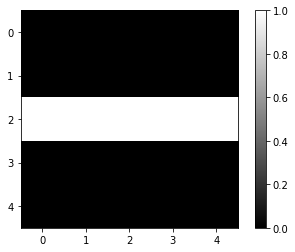

In [10]:
plt.imshow(image1[0,0,:,:].numpy(),interpolation='nearest',cmap=plt.cm.gray)
plt.colorbar()
plt.show()

In [13]:
conv1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3)
conv1.state_dict()

OrderedDict([('weight', tensor([[[[ 0.0067, -0.1090,  0.0653],
                        [-0.2699, -0.3227,  0.1913],
                        [-0.2483, -0.1949, -0.0818]]],
              
              
                      [[[ 0.0576,  0.0624,  0.0517],
                        [ 0.2165, -0.2231, -0.0102],
                        [-0.0422, -0.2407, -0.2644]]],
              
              
                      [[[ 0.0684, -0.1069,  0.1384],
                        [-0.2560,  0.0364, -0.1857],
                        [-0.2789,  0.0852,  0.3200]]]])),
             ('bias', tensor([ 0.3006,  0.2495, -0.2534]))])

In [14]:
Gx = torch.tensor([[1,0,-1],[2,0,-2],[1,0,-1]])
Gy = torch.tensor([[1,2,1],[0,0,0],[-1,2,-1]])

conv1.state_dict()['weight'][0][0] = Gx
conv1.state_dict()['weight'][1][0] = Gy
conv1.state_dict()['weight'][2][0] = torch.ones(3,3)

In [18]:
conv1.state_dict()['bias'][:] =torch.tensor([0,0,0])
conv1.state_dict()

OrderedDict([('weight', tensor([[[[ 1.,  0., -1.],
                        [ 2.,  0., -2.],
                        [ 1.,  0., -1.]]],
              
              
                      [[[ 1.,  2.,  1.],
                        [ 0.,  0.,  0.],
                        [-1.,  2., -1.]]],
              
              
                      [[[ 1.,  1.,  1.],
                        [ 1.,  1.,  1.],
                        [ 1.,  1.,  1.]]]])), ('bias', tensor([0., 0., 0.]))])

In [19]:
out = conv1(image1)
out

tensor([[[[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [4., 4., 4.]],

         [[3., 3., 3.],
          [3., 3., 3.],
          [3., 3., 3.]]]], grad_fn=<ThnnConv2DBackward>)

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]], grad_fn=<SelectBackward>)


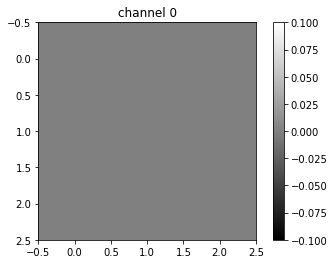

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [4., 4., 4.]], grad_fn=<SelectBackward>)


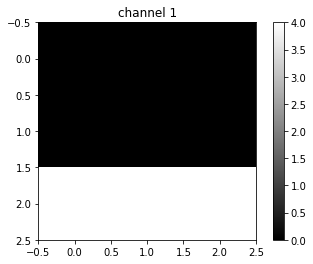

tensor([[3., 3., 3.],
        [3., 3., 3.],
        [3., 3., 3.]], grad_fn=<SelectBackward>)


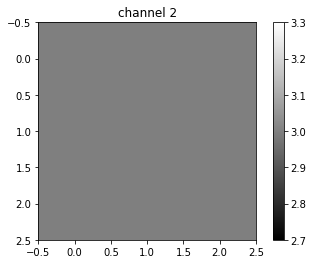

In [25]:
for channel, image in enumerate(out[0]):
    plt.imshow(image.detach().numpy(), interpolation='nearest', cmap=plt.cm.gray)
    print(image)
    plt.title("channel {}".format(channel))
    plt.colorbar()
    plt.show()

In [26]:
# Define the function for plotting the channels

def plot_channels(W):
    n_out = W.shape[0]
    n_in = W.shape[1]
    w_min = W.min().item()
    w_max = W.max().item()
    fig, axes = plt.subplots(n_out, n_in)
    fig.subplots_adjust(hspace=0.1)
    out_index = 0
    in_index = 0
    
    # plot outputs as rows inputs as columns
    for ax in axes.flat:
        if in_index > n_in-1:
            out_index = out_index + 1
            in_index = 0
        ax.imshow(W[out_index, in_index, :, :], vmin=w_min, vmax=w_max, cmap='seismic')
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        in_index = in_index + 1
        
    plt.show()

In [ ]:
# Define the function for plotting the parameters
def plot_parameters(W, number_rows=1, name="", i=0):
    W = W.data[:,i,:,:]
    n_filters = W.shape[0]
    w_min = W.min().item()
    w_max = W.max().item()
    fig, axes = plt.subplots(number_rows, n_filters//number_rows)
    fig.subplots_adjust(hspace=0.4)
    
    for i,ax in enumerate(axes.flat):
        if i<n_filters:
            # set the label for the subplot
            ax.set_xlabel("kernel:{0}".format(i+1))
            
            # plot the image
            ax.imshow(W[i,:],vmin=w_min,vmax=w_max,cmap='seismic')
            ax.set_xticks([])
            ax.set_yticks([])
    plt.suptitle(name,fontsize=10)
    plt.show()

In [27]:
# Define the function for plotting the activations
def plot_activations(A, number_rows=1, name="", i=0):
    A = A[0,:,:,:].detach().numpy()
    n_activations = A.shape[0]
    A_min = A.min().item()
    A_max = A.max().item()
    fig, axes = plt.subplots(number_rows, n_activations//number_rows)
    fig.subplots_adjust(hspace=0.4)
    
    for i,ax in enumerate(axes.flat):
        if i < n_activations:
            # Set the label for the subplot 
            ax.set_xlabel("activation:{0}".format(i+1))
            
            # plot the image
            ax.imshow(A[i,:], vmin=A_min, vmax=A_max, cmap='seismic')
            ax.set_xticks([])
            ax.set_yticks([])
    plt.show()

In [28]:
def show_data(data_sample):
    plt.imshow(data_sample[0].numpy().reshape(IMAGE_SIZE,IMAGE_SIZE),cmap='gray')
    plt.title('y= '+ str(data_sample[1].item()))